# Importing Libraries

In [9]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 3.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [6]:
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haripriyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
import warnings
warnings.filterwarnings('ignore')

# Loading Dataset

In [49]:
data = pd.read_csv('/Users/haripriyan/Documents/Python_Projects/DetectingSpamEmailsUsingTensorflowPython/data/Emails.csv')
data.head(10)

,text,spam
0,"Subject:""Congratulations! You've won a prize!""",1
1,"Subject: ""Meeting agenda for tomorrow""",0
2,"Subject: ""Update your account information""",1
3,"Subject: ""Exclusive deal just for you!""",1
4,"Subject: ""Your order has been shipped""",0
5,"Subject: ""Urgent: Verify your identity""",1
6,"Subject: ""Lunch plans?""",0
7,"Subject: ""Limited time offer!""",1
8,"Subject: ""Important security notice""",1
9,"Subject: ""Project update attached""",0


# Printing the shape of the data frame.

In [50]:
data.shape

(704, 2)

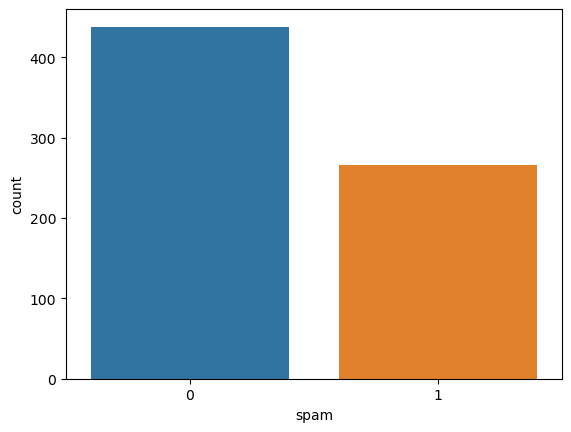

In [51]:
sns.countplot(x='spam', data=data)
plt.show()


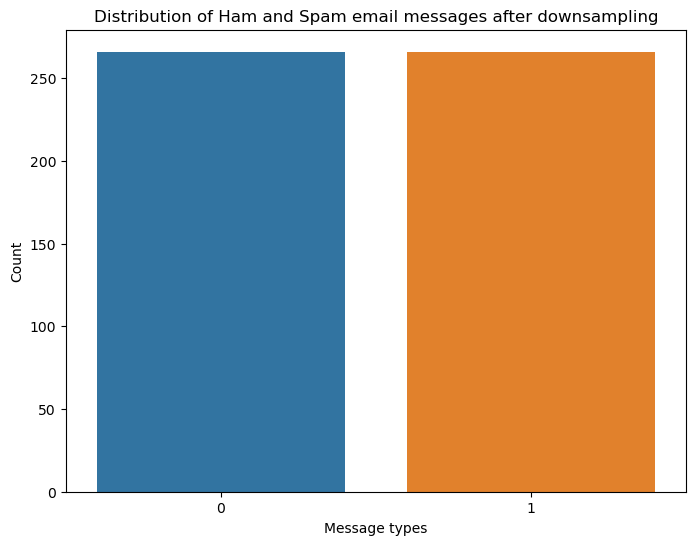

In [55]:
# Downsampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)

# Plotting the counts of down-sampled dataset
balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')
plt.ylabel('Count')
plt.show()


# Text Preprocessing

# Model Development and Evaluation
We will implement a Sequential model

Three Embedding Layers to learn featured vector representations of the input vectors.
An LSTM layer to identify useful patterns in the sequence.
Then we will have one fully connected layer.
The final layer is the output layer which outputs probabilities for the two classes. 


In [58]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['spam'],
                                                    test_size = 0.2,
                                                    random_state = 42)


In [59]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
maxlen=max_len, 
padding='post', 
truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')


In [60]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           12192     
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15905 (62.13 KB)
Trainable params: 15905 (62.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                                                        metrics = ['accuracy'],
                                                        optimizer = 'adam')


In [69]:
# Callbacks
es = tf.keras.callbacks.EarlyStopping(
    patience=3,
    monitor='val_loss',  # Change to val_loss if it's more appropriate
    restore_best_weights=True
)

lr = tf.keras.callbacks.ReduceLROnPlateau(
    patience=2,
    monitor='val_loss',
    factor=0.5,
    verbose=1  # Set to 1 for more detailed logging
)

# Train the model

In [71]:
# Train the model
history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=10,
    batch_size=32,
    callbacks=[es, lr],  # Ensure the callbacks are in the list
    verbose=1  # Set to 1 for detailed logs
)

Epoch 1/10
14/14 [==============================] - 0s 9ms/step - loss: 0.6932 - accuracy: 0.4871 - val_loss: 0.6931 - val_accuracy: 0.5514 - lr: 6.2500e-05
Epoch 2/10
14/14 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4753 - val_loss: 0.6932 - val_accuracy: 0.4486 - lr: 6.2500e-05
Epoch 3/10
 9/14 [==================>...........] - ETA: 0s - loss: 0.6931 - accuracy: 0.5278
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
14/14 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5129 - val_loss: 0.6932 - val_accuracy: 0.4486 - lr: 6.2500e-05
Epoch 4/10
14/14 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6933 - val_accuracy: 0.4486 - lr: 3.1250e-05


# Evaluate the model

In [72]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


4/4 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5514
Test Loss : 0.6930927038192749
Test Accuracy : 0.5514018535614014


# Model Evaluation Results

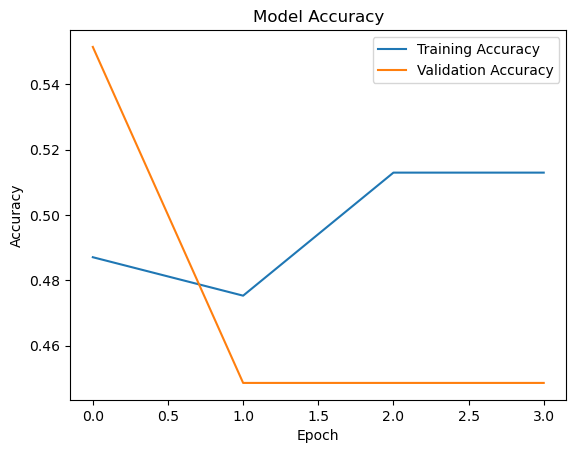

In [73]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
